In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from spline import *
from utils import read_pgm, read_eye_annotations, read_patch, read_norm_img
from scipy.signal import convolve2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect patches

In [14]:
import os


n_patches = 1000

patches = np.zeros((n_patches , 101, 101))

for i in range(n_patches):
    patch = read_patch(i, loc='left')

    patches[i] = patch

# Average model (A) TEST

## Fit the model

(1.734193262751288e-06, 0.00012247211628040207)

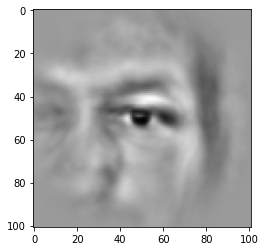

In [15]:
from models.averager import Averager
avg = Averager()
avg.train(patches, n_order=16)

# Display template
plt.imshow(avg.template, cmap='gray')
np.mean(avg.template), np.std(avg.template)

## Collect image and test

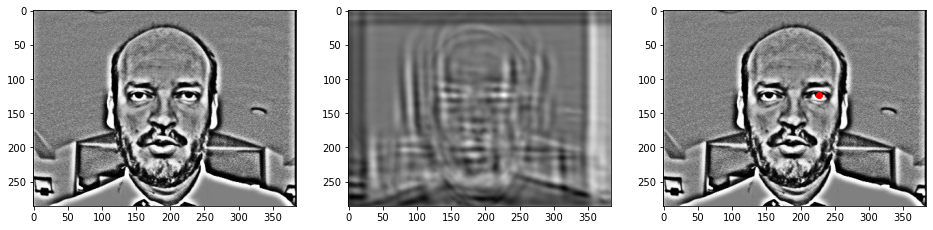

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
image = read_norm_img(17)



conv, (x, y) = avg.predict_im(image, ax3)

ax1.imshow(image, cmap='gray')
ax2.imshow(conv, cmap='gray')


In [17]:
Nx = Ny = 101  # Size of training samples
Nk = 51  # Size of the patches (x-direction)
Nl = 51  # Size of the patches (y-direction)
spline_deg = 3  # Degree of the B-spline used

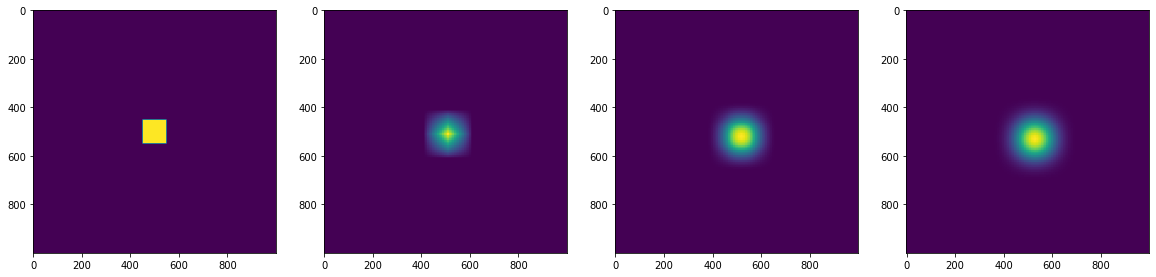

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 35))


Nx = Ny = 101
Nk = Nl = 51

sk = Nx / Nk
sl = Ny / Nk


x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

B2d = make_2D_spline_deg_n(0, sk=sk, sl=sl)
ax1.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(1, sk=sk, sl=sl)
ax2.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(2, sk=sk, sl=sl)
ax3.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(3, sk=sk, sl=sl)
ax4.imshow(B2d(x, y))


In [19]:
import numpy as np
from scipy.signal import convolve2d


class LinRegR2(object):

    def __init__(self, mu=0, verbose=0):
        """
        """
        self.S_matrix = None
        self.template = None
        self.pupil_location = None
        self.mu = mu
        self.verbose = verbose


    def __make_s_vector(self, Nx, Ny, Nk, Nl, train_patches, spline_deg=2):
        """
        Create the S matrix

        Inputs:
        -------

        Nx (int): The size of reference image x-axis
        Ny (int): The size of reference image y-axis
        Nk (int): The number of splines x-axis
        Nl (int): The number of splines y-axis
        train_patches (array): Array of shape (num_patch, patch_size) with the training samples
        spline_deg (int): The spline degree to use 
        """

        sk = Nx / Nk
        sl = Ny / Nl

        num_patch = train_patches.shape[0]

        self.S_matrix = np.zeros((num_patch, Nk * Nl))

        # Define splines
        x = np.array(range(-int( 5 * sk /2) , int( 5 * sk /2) + 1 )) / sk
        y = np.array(range(-int( 5 * sl /2), int( 5 * sl /2) + 1 )) / sl

        # Define 2D splines
        B = discrete_spline_2D(x, y, spline_deg)

        # Generate k, l coordinates 
        k = np.array(range(0, 51))
        l = np.array(range(0, 51))

        # Convert them to x, y coordinate for mapping
        x, y = spline_kl_to_xy(k, l, sk, sl)
        
        
        for i in range(num_patch):

            if self.verbose and i % 100 == 0:
                print('Patch {}'.format(i))

            S_matrix_i = convolve2d(train_patches[i], B,  mode='same')

            # Get the corresponding points in(x, y) grid and flatten
            self.S_matrix[i] = S_matrix_i[x, :][:, y].flatten()


    def train(self, Nx, Ny, Nk, Nl, train_patches, labels, spline_deg=2):

        self.__make_s_vector(Nx, Ny, Nk, Nl, train_patches, spline_deg)
        
        A = np.dot(self.S_matrix.T, self.S_matrix)
        A += self.mu * np.identity(A.shape[0])
        b = np.dot(self.S_matrix.T, labels)

        c = np.linalg.lstsq(A, b)

        self.spline_coef = c[0]


        

    def make_temp_from_spline(self, spline_deg=3, Nk=51, Nl=51, sk=1, sl=1):

        
        def template(x, y):

            s = 0

            k = np.array(range(- int(Nk / 2), int(Nk /2) +1))
            l = np.array(range(- int(Nk / 2), int(Nk /2) +1))

            x, y = xy_to_kl(x, y, sk, sl)


            B = discrete_spline_2D(x - k * sk, y - l * sl, spline_deg).reshape(1, Nk * Nl)


            return np.dot(B[np.newaxis, :], self.spline_coef)

        return template






        

In [20]:
n_patches = 1000

pos_patches = np.zeros((n_patches , 101, 101))
pos_labels = np.ones((n_patches , 1))

neg_patches = np.zeros((n_patches , 101, 101))
neg_labels = np.zeros((n_patches , 1))

for i in range(n_patches):
    pos_patch = read_patch(i, loc='left', pos_neg="positive")
    neg_patch = read_patch(i, loc='left', pos_neg="negative")
    
    pos_patches[i] = pos_patch
    neg_patches[i] = neg_patch

In [21]:
# plt.imshow(pos_patches[0], cmap='gray')
# plt.show()
# 
# plt.imshow(neg_patches[0], cmap='gray')
# plt.show()

In [22]:
train_patches = np.vstack((pos_patches, neg_patches))
train_labels =  np.vstack((pos_labels, neg_labels))

In [48]:
lin = LinRegR2(mu=1e7)
lin.train(Nx, Ny, Nk, Nl, train_patches=train_patches, labels=train_labels, spline_deg=3)

/home/pierreglaser/.virtualenvs/geodesic_methods/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


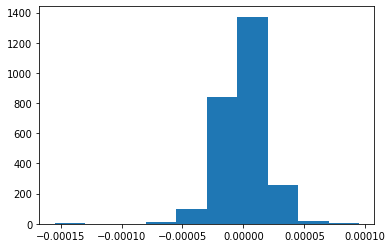

In [49]:
_ = plt.hist(lin.spline_coef.flatten())

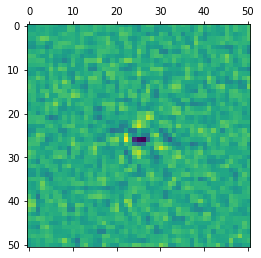

In [50]:
plt.matshow(lin.spline_coef.reshape(51, 51))

In [51]:
center_splines_range_k = np.array(range(- int(Nk / 2), int(Nk /2) +1))
center_splines_range_l = np.array(range(- int(Nl / 2), int(Nl /2) +1))

sk = Nx / Nk
sl = Ny / Nl

# Define splines
indiv_spline_range_x = np.array(range(-int( 5 * sk /2) , int( 5 * sk /2) + 1 )) / sk
indiv_spline_range_y = np.array(range(-int( 5 * sl /2), int( 5 * sl /2) + 1 )) / sl


B = discrete_spline_2D(indiv_spline_range_x, indiv_spline_range_y, 3)

In [52]:
from itertools import product

final_template = np.zeros((Nx, Ny))
print(final_template.shape)

idx = 0
for center_k in center_splines_range_k:
    for center_l in center_splines_range_l:
        center_x, center_y = spline_kl_to_xy(center_k, center_l, sk, sl)

        # move from -x, x indexing to 0, 2x indexing
        center_x += (Nx - 1) // 2
        center_y += (Ny - 1) // 2
        # print(center_k, center_l)
        min_slice_x = center_x - (len(indiv_spline_range_x) - 1) // 2
        max_slice_x = center_x + (len(indiv_spline_range_x) + 1) // 2

        min_slice_y = center_y - (len(indiv_spline_range_y) - 1) // 2
        max_slice_y = center_y + (len(indiv_spline_range_y) + 1) // 2

        if min_slice_x < 0 or min_slice_y < 0:
            idx += 1
            continue

        if max_slice_x > Nx or max_slice_y > Ny:
            idx += 1
            continue

        slice_x, slice_y = slice(min_slice_x, max_slice_x), slice(min_slice_y, max_slice_y)
        final_template[slice_x, slice_y]  += lin.spline_coef[idx] * B
        idx+=1

(101, 101)


In [53]:
from models.utils import make_template_mass
mask = make_template_mass(int(Nx/2))

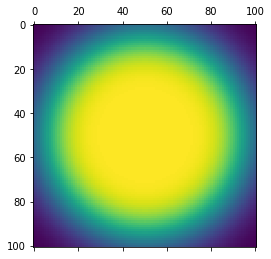

In [54]:
plt.matshow(mask)

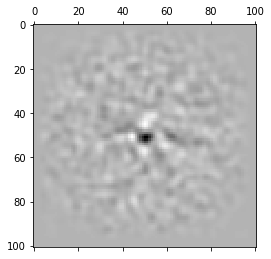

In [55]:
plt.matshow(mask * final_template, cmap='gray')

In [95]:
spline_kl_to_xy(51, 51, Nx/Nk, Ny/Nl)

(101, 101)

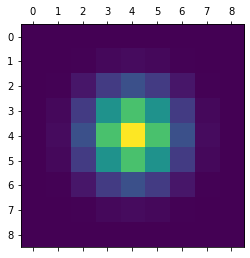

In [77]:

plt.matshow(
    np.outer(discrete_spline(indiv_spline_range_x, 3), discrete_spline(indiv_spline_range_y, 3)))

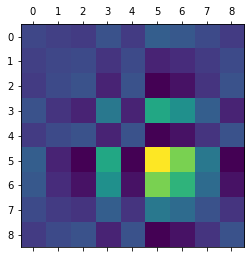

In [71]:

plt.matshow(B)

In [29]:
import numpy, math
np.math.factorial

<function math.factorial(x, /)>

In [22]:
np.maximum(np.power([1, 2], 2), 0)

array([1, 4])

In [28]:
(dim_y, dim_x) = Nx, Ny
X = np.array(range(2 * dim_x + 1, 4 * dim_x + 1))
Y = np.array(range(2 * dim_y + 1, 4 *  dim_y + 1))

temp = np.array([[lin.make_temp_from_spline()(x,y) for x in X] for y in Y])


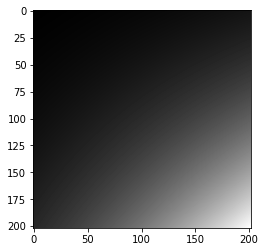

In [31]:
plt.imshow(temp.reshape(202, 202), cmap='gray')

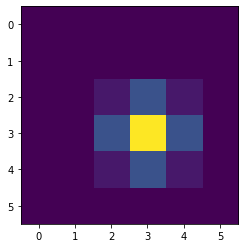

In [32]:
k = np.array(range(- int((2 * spline_deg + 1) / 2), int((2 * spline_deg + 1) / 2)))
l = np.array(range(- int((2 * spline_deg + 1) / 2), int((2 * spline_deg + 1) / 2)))

B = discrete_spline_2D(k, l, spline_deg)

plt.imshow(B)

In [33]:
from spline import xy_to_kl

def template(x, y):

            s = 0

            k = np.array(range(- int(Nk / 2), int(Nk /2) +1))
            l = np.array(range(- int(Nk / 2), int(Nk /2) +1))

            k = np.array(range(0, Nk))
            l = np.array(range(0, Nk))

            #x, y = xy_to_kl(x, y, sk, sl)


            B = discrete_spline_2D(x - k * sk, y - l * sl, spline_deg).reshape(Nk * Nl)


            return np.dot(B[np.newaxis, :], lin.spline_coef)

In [34]:
from spline import xy_to_kl

def template_bis(x, y):

    s = 0

    k = np.array(range(-int( 5 * sk /2) + 1, int( 5 * sk /2) + 1 )) / sk
    l = np.array(range(-int( 5 * sl /2) + 1, int( 5 * sl /2) + 1 )) / sl    

    x, y = xy_to_kl(x, y, sk, sl)



    B = discrete_spline_2D(k, l, spline_deg)

    c = lin.spline_coef.reshape(Nk, Nl)

    conv = convolve2d(c, B,  mode='same')



    return conv

In [35]:
template_bis(0, 1)

array([[-1.20298746e-04, -1.53834299e-04, -1.05018117e-04, ...,
         2.63183788e-05,  4.12592188e-05,  1.06089155e-04],
       [ 1.13846081e-04, -3.13768246e-06, -4.72199716e-05, ...,
         3.11819053e-05,  3.79786695e-05,  8.06723941e-05],
       [ 2.41583000e-04,  5.48999126e-05, -4.71196451e-05, ...,
         1.50163630e-05,  1.60537604e-05,  3.28911509e-05],
       ...,
       [ 3.55729897e-05,  3.98198564e-05,  3.24947048e-05, ...,
         3.70783200e-05, -1.51006895e-05, -3.36065682e-05],
       [-1.80314518e-05, -2.80377900e-05, -1.11965206e-05, ...,
         2.22006761e-05, -2.07518485e-05, -1.81099038e-05],
       [-7.54248100e-05, -4.21386043e-05,  6.59598029e-06, ...,
         2.03289401e-05,  5.02711450e-06, -8.32213022e-07]])

In [36]:
(dim_y, dim_x) = Nx, Ny
X = np.array(range(- int(dim_x / 2), int(dim_x / 2 ) + 1))
Y = np.array(range(- int(dim_y / 2), int(dim_y / 2 ) + 1))

X = np.array(range(0, dim_x))
Y = np.array(range(0, dim_y))

temp = np.array([[template(x,y) for x in X] for y in Y])

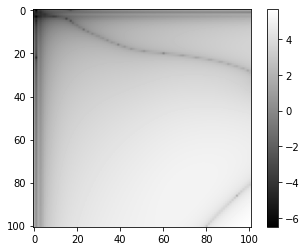

In [43]:
plt.imshow(np.log10(np.abs(temp.reshape(101, 101))), cmap='gray')
plt.colorbar()

In [46]:
from scipy.interpolate import bisplrep
from scipy.interpolate import bisplev

In [ ]:
x, y = np.mgrid[-1:1:101j, -1:1:101j]

#x, y = np.meshgrid(x, y)
tck = bisplrep(x, y, temp, s=0)

x, y = np.mgrid[-1:1:202j, -1:1:202j]

#x_new, y_new = np.meshgrid(x_new, y_new)

inter = bisplev(x_new[:,0], y_new[0,:], tck)

In [ ]:
temp

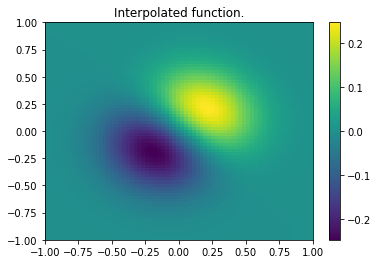

In [221]:
x, y = np.mgrid[-1:1:20j, -1:1:20j]
z = (x+y) * np.exp(-6.0*(x*x+y*y))

xnew, ynew = np.mgrid[-1:1:70j, -1:1:70j]
tck = bisplrep(x, y, z, s=0)
znew = bisplev(xnew[:,0], ynew[0,:], tck)

plt.figure()
plt.pcolor(xnew, ynew, znew)
plt.colorbar()
plt.title("Interpolated function.")
plt.show()

In [223]:
x.shape

(20, 20)